# Predicting house price in King County, WA

Jerry Chen

## Pacakge required

`folium` for the geo heat map. Installation `pip install folium`.

Other common packages:
`pandas`, `numpy`, `seaborn`, `statsmodels.api`, `sklearn`, `matplotlib`

In [1]:
# import packages
import pandas as pd 
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap
%matplotlib inline

## Dataset Description

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. It's a great dataset for evaluating regression models.

The dataset is retrieved from Kaggle (https://www.kaggle.com/harlfoxem/housesalesprediction). It is published on 08/25/2016.
The source is believed to be reliable because all housing information is public data. It is a famous dataset, and the features are complete. 

I chose this topic is because predicting the expected (house) price is a typical topic for business analyst. I think it is a great chance for us to have hands-on practice.

Along with house price (target) it consists of an ID, date, and 18 house features.


1. `Id`:  Unique ID for each home sold
2. `Date`: Date of the home sale
3. `Price`: Price of each home sold (target)
4. `Bedrooms`: Number of bedrooms
5. `Bathrooms`: Number of bathrooms, where .5 accounts for a room with a toilet but no shower
6. `Sqft_living`: Square footage of the apartments interior living space
7. `Sqft_lot`: Square footage of the land space
8. `Floors`: Number of floors
9. `Waterfront`: A dummy variable for whether the apartment was overlooking the waterfront or not
10.`View`: An index from 0 to 4 of how good the view of the property was
11.`Condition`: An index from 1 to 5 on the condition of the apartment,
12. `Grade`: An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
13. `Sqft_above`: The square footage of the interior housing space that is above ground level
14. `Sqft_basement`: The square footage of the interior housing space that is below ground level
15. `Yr_built`: The year the house was initially built
16. `Yr_renovated`: The year of the house’s last renovation
17. `Zipcode`: What zipcode area the house is in
18. `Lat`: Lattitude
19. `Long`: Longitude
20. `Sqft_living15`: The square footage of interior housing living space for the nearest 15 neighbors
21. `Sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors


## Read in and Clean Dataset 

In [2]:
# read the dataset
data = pd.read_csv("./kc_house_data.csv")

In [3]:
pd.set_option('display.max_columns', 25) # we want to see all columns
data.head() # show the first 5 rows to see the data structure

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# checking the datatype and number of nulls and rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


The data is clean and no nulls exists in the dataset. It has 21613 rows of house price data. Except of the `date`, all columns are numeric, so we don't need to handle dummy variables. Note that some features like `grade` are ordinal (categorical), it is not a continous number.

### Data Aggregation

In [5]:
# we want to preprcess the `data` and extract the year in order to calcuate the age of the house.
data['year_sold'] = pd.to_datetime(data['date']).dt.date.astype('datetime64[ns]')
data['year_sold'] = pd.DatetimeIndex(data['year_sold']).year # extract only year

In [6]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015


In [7]:
# we want to drop the `id`  and `date` becasue it is not useful for our analysis
data.drop(['id', 'date'], axis = 1, inplace = True)

In [8]:
# we want to know about the age of the house
data['age_built'] = (data['year_sold'] - data['yr_built']).astype(int)

In [9]:
# calculate the years from renovation to sold. if no reno happenned, then consider the built year as first reno.
conditions = [data['yr_renovated'] == 0, data['yr_renovated'] != 0]
choices_age = [data['year_sold'] - data['yr_built'], data['year_sold'] - data['yr_renovated']]
data['age_renovated'] = np.select(conditions, choices_age)
# we want to know if the house have renovation (True/False)
choices_done_reno = [0, 1]
data['done_reno'] = np.select(conditions, choices_done_reno)

In [10]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,age_built,age_renovated,done_reno
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,59,59,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,63,23,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,82,82,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,49,49,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,28,28,0


Now, everything looks great. The data looks clean and provide useful informtaion. Let's do some data exploration and visualization beofre we build the model to see if we need more processing of our data. After we finalize the dataframe, we will do `train_test_split` right before we build the model.

### Binning the `age_built`

Let's binning the `age_built` and see the distribution.

In [11]:
bins = [-2, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 100000]
labels = ['<1', '1-10', '11-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100'] # e.g., (1-10]
data['age_built_binned'] = pd.cut(data['age_built'], bins = bins, labels = labels)

In [12]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,age_built,age_renovated,done_reno,age_built_binned
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,59,59,0,50-60
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,63,23,1,60-70
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,82,82,0,80-90
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,49,49,0,40-50
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,28,28,0,20-30


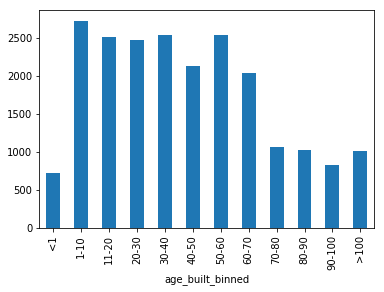

In [13]:
data.groupby('age_built_binned')['price'].count().plot.bar()
plt.show()

The age of most houses are ranging from 1 to 70 years. (Details can be found in EDA section.)

## Exploratory Data Analysis

In [14]:
# find the quick summary of the data
data.describe(include = 'all')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,age_built,age_renovated,done_reno,age_built_binned
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-10
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2729
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,2014.322954,43.317818,40.936936,0.042289,NaN
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.467616,29.375493,28.813643,0.201253,NaN
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,-1.000000,-1.000000,0.000000,NaN
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000,18.000000,15.000000,0.000000,NaN
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000,40.000000,37.000000,0.000000,NaN
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,63.000000,60.000000,0.000000,NaN


### Summary of the dataset:
We can find the `price` (target has a wide range of distribution because it has a very high standard deviation. We want to take a closer look at `price` later. We will focus on the median rather than the mean because we can see many outliers, which will influence the mean. The median price is 450,000 dollars. The median number of `bedroom` is 3, so it might imply the most people get a mid-size house in King County. The `bathroom` is a little bit tricky because we have decimal points in the data, which includes half-bath or powder room, etc. We can see most homeowners have a little bit more than two full bathrooms. We can also see that the `sqft_living` distributed in a very wide range, which may be one of the reasons that price varies in a wide range as well. The sqft footage ranging from 290 sqft to 13,530 sqft, and the median sqft is 1,910, which is about the same as what I observed in the Seattle area. We can see the median people have 1.5 floors. However, most people don't have a house close to the `waterfront`, and there is no special `view`. (We're not Bill Gates) People tend to buy a house with the `condition` of 3 (okay) and a grade of 7 (out of 13). People tend to buy square footage above the ground rather than the basement space. We can see the median of people don't have a basement. It doesn't make sense when we look at the median or the mean of `yr_built`, `yr_renovated`, `zipcode`, `lat`, and `long`. We should treat them more like the categorical data. I keep these columns because we can do data visualization on the `lat` and `long` later, and we can further calculate some aggregated features, like `age_built` and `age_renovated`. I keep the neighborhood information to see if the sqft of lot and living space have a high correlation of the house people bought. If it has a high correlation, it means the zone influence the size of the house. We can see the median of `age_built` and `age_renovated` are about 40 years, and the numbers are pretty close, which means that not a lot of hold sold have renovated (`done_reno`). Only 4.2% houses have done rennovation. 

### Use boxplot to find the price distribution

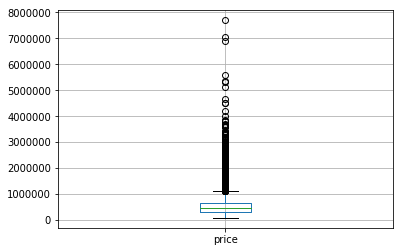

In [15]:
data.boxplot(column = 'price')
plt.show()

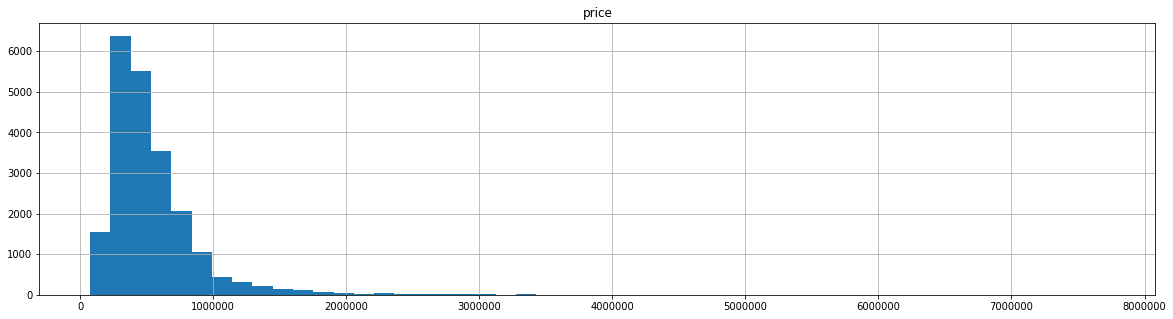

In [16]:
data.hist(column = 'price', bins = 50, figsize = (20, 5))
plt.show()

The price distribution is a positively skewed data. We can see a lot of outliers as we expected. i.e. it has a very wide price range, but it doesn't mean the data is wrong here.

### Use QQ plot to see if the `price` and `sqft_living` and `age_built` follows the normal distribution

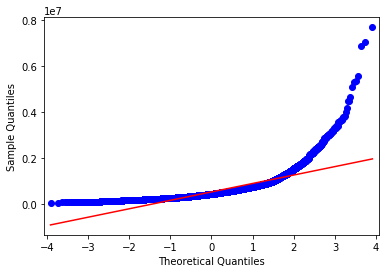

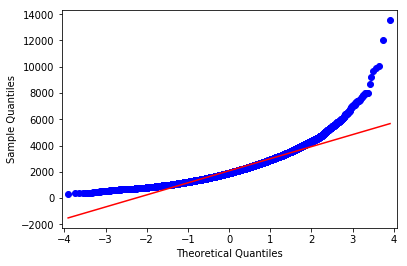

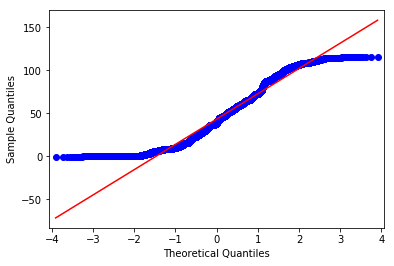

In [17]:
sm.qqplot(data['price'], line='s')
sm.qqplot(data['sqft_living'], line='s')
sm.qqplot(data['age_built'], line='s')
plt.show()

None of them follows the normal distribution.

### Correlation Table

Let's look at the correlation between each features, and we want to explore any features that closely associate with `price`. 

In [18]:
house_corr = data.corr()

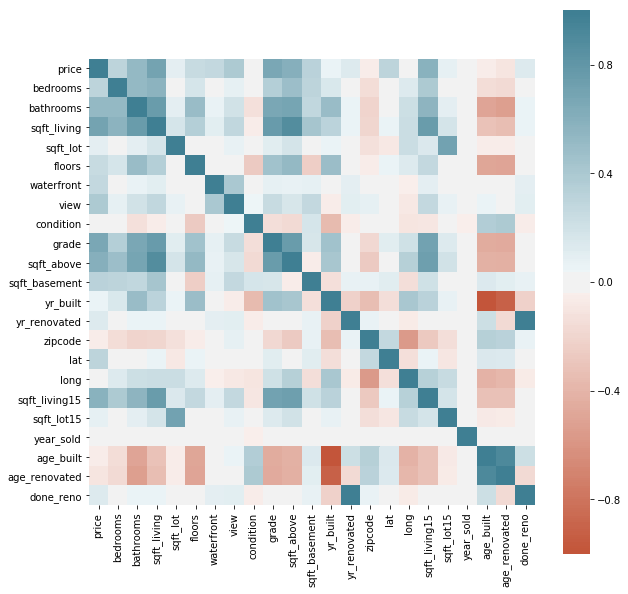

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(house_corr, 
    xticklabels = house_corr.columns.values, # x labels
    yticklabels = house_corr.columns.values, # y labels
    vmin = -1, # color scale the min value
    vmax = 1, # color scale the max
    center = 0, # color scale place at the center at 0
    cmap = sns.diverging_palette(20, 220, n = 200), # color palette
    square = True) # each cell will be square-shaped
plt.show()

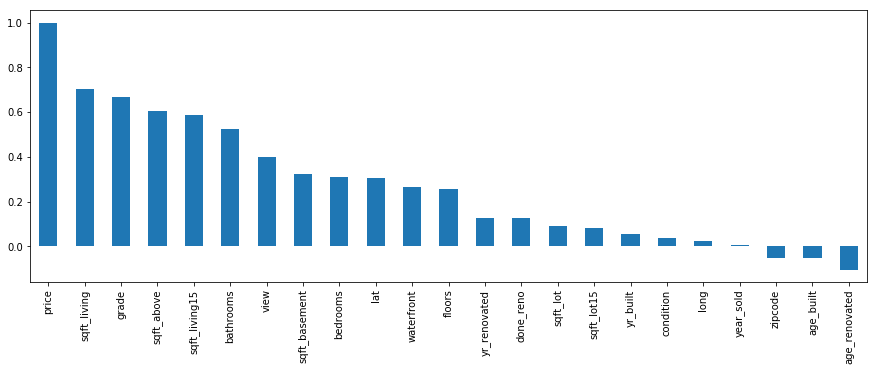

In [20]:
house_corr['price'].sort_values(ascending = False).plot.bar(figsize=(15,5))
plt.show()

From the chart, we found out `price` is closely associated with `sqrt_living` , `grade`, `sqft_above`, `sqrt_living15`, `bathrooms`, and `views`, which are not surprised us. The more space you got, the higher the price you will get. On the other hand, when the age is less for built and renovated, the price is higher. (i.e., the newer house got a better price). This is as expected as we think in the market.  

Most houses don't have a basement, so the living footage (`sqrt_living`) is positively correlated with `sqft_above`

Also, we are not surprised to see the neighborhood living space (`sqrt_living15`) and lot space (`sqrt_lot15`) are correlated with the house living space (`sqrt_living`) and lot pace(`sqrt_lot`). The similar types of houses tend to gather together.

Note that it is natural to see the `yr_built` is negatively correlated with `age_built` (aggregated feature). 

### Data Visualization

 Let's look at if the `price` goes with the trend of other features.

#### Price vs. Living Space

Does larger living space sell at a better price?

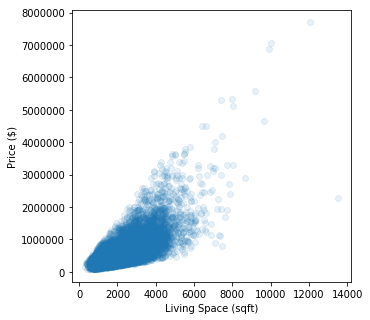

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(data['sqft_living'], data['price'], alpha = 0.1)
plt.xlabel("Living Space (sqft)")
plt.ylabel("Price ($)")
plt.show()

We can see the `price` and `sqft_living` is positively correlated. 

#### Price vs. Grade
Does better grade sell at a better price?

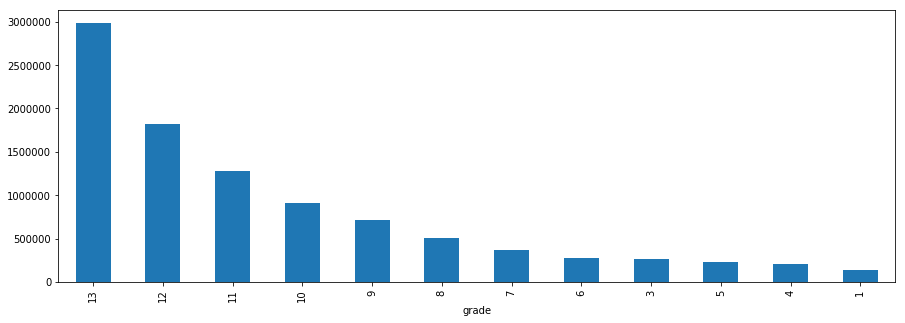

In [22]:
price_grade_med = data.groupby("grade")['price'].median()
price_grade_med.sort_values(ascending = False).plot.bar(figsize=(15,5))
plt.show()

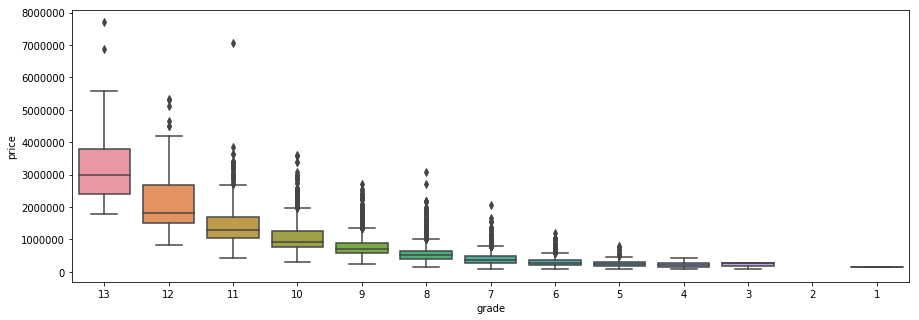

In [23]:
plt.figure(figsize=(15, 5))
orders = list(reversed(range(1, 14)))
sns.boxplot(x = data['grade'], y = data['price'], order = orders)
plt.show()

Yes, mostly! The better grade comes with a higher price.   
ps. grade 3 has fewer data and it has higher median price, and there is no grade 2 data.

#### Price vs. bathrooms
Can we sell at a better price if we have more bathrooms?

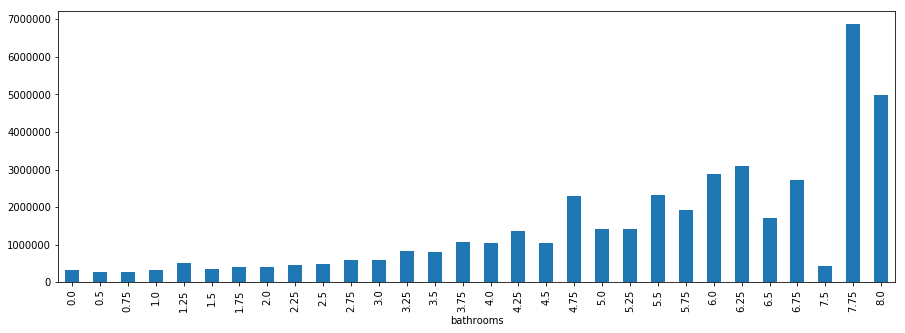

In [24]:
price_bathrooms_med = data.groupby("bathrooms")['price'].median()
price_bathrooms_med.plot.bar(figsize=(15,5))
plt.show()

In [25]:
data.groupby("bathrooms")['price'].count()

bathrooms
0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3048
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: price, dtype: int64

Generally! More bathrooms come with a higher price. 7.5 bothrooms doen't have a good price but because we only have one data point. We can see the trend (more bathrooms, higher price) is valid when we have more data points.   

#### Price vs. view
Is it more pricy if the house has better view?

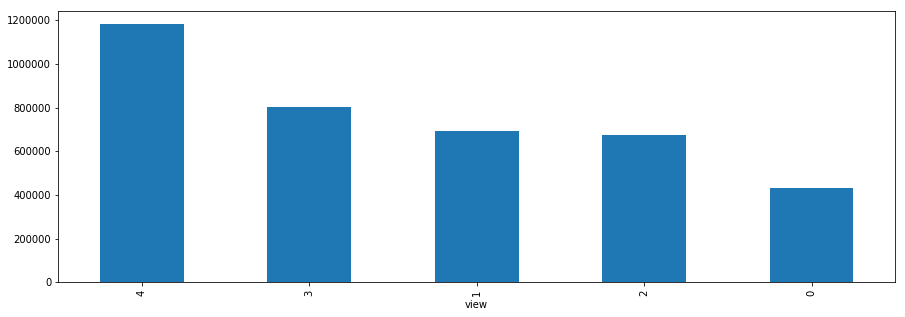

In [26]:
price_bathrooms_med = data.groupby("view")['price'].median()
price_bathrooms_med.sort_values(ascending = False).plot.bar(figsize=(15,5))
plt.show()

Mostly! better view comes with a higher price.

#### Price vs. `done_reno`
Can a house sell more if it has rennovation?

done_reno
0    448000.0
1    600000.0
Name: price, dtype: float64


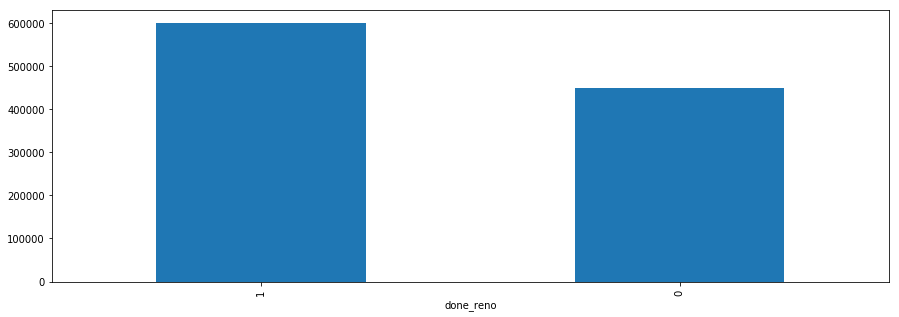

In [27]:
price_donereno_med = data.groupby("done_reno")['price'].median()
print(price_donereno_med)
price_donereno_med.sort_values(ascending = False).plot.bar(figsize=(15,5))
plt.show()

The house with rennovation can sell a slightly better price.

#### Price vs. age of the house
Is the price higher when the house is newer?

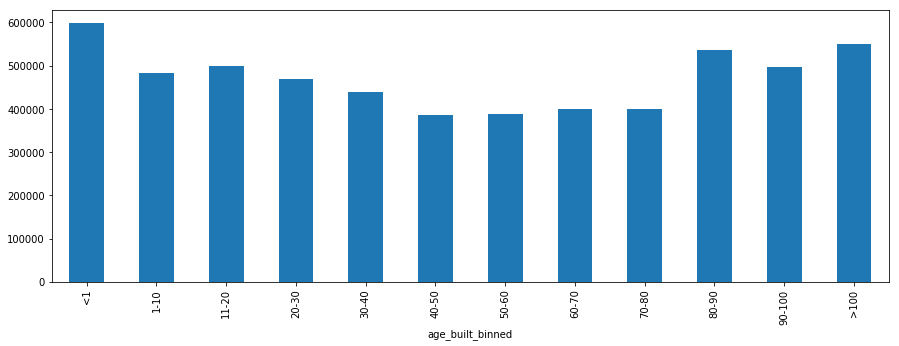

In [28]:
price_age_built_binned_med = data.groupby("age_built_binned")['price'].median()
price_age_built_binned_med.plot.bar(figsize=(15,5))
plt.show()

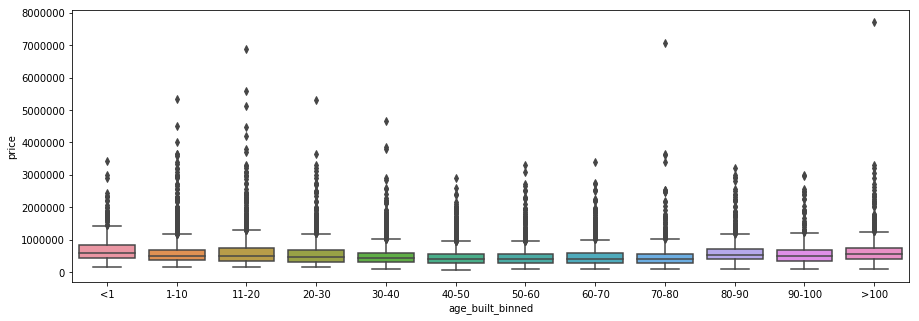

In [29]:
plt.figure(figsize=(15, 5))
sns.boxplot(x = data['age_built_binned'], y = data['price'])
plt.show()

In [30]:
data.groupby("age_built_binned")['price'].count()

age_built_binned
<1         727
1-10      2729
11-20     2518
20-30     2471
30-40     2535
40-50     2132
50-60     2542
60-70     2033
70-80     1058
80-90     1026
90-100     830
>100      1012
Name: price, dtype: int64

If we only look at the median price, it holds true only when the house is between 11 to 50 years old. Surprisingly, the houses over 50 years start to increase their values. (Maybe they beomce antiques). As we found out in the correlation table, the house age dosn't have strong (nagatively) correlation between the house age and the price. 

#### Square Footage Analysis
`sqft_living` vs. `sqft_living15` and `sqft_living` vs. `sqft_above`

Is living space of the house similar to its neighborhood?  
Does most people buy living spaces above the ground?

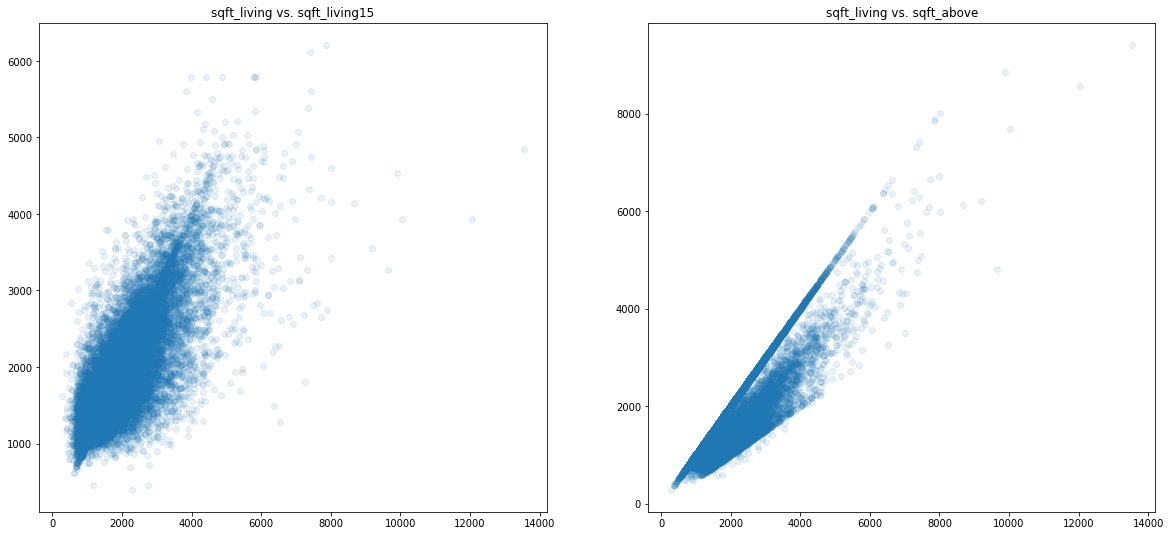

In [31]:
f = plt.figure(figsize=(20, 9))
ax1 = f.add_subplot(121)
ax1.scatter(data['sqft_living'], data['sqft_living15'], alpha = 0.1)
ax1.set_title("sqft_living vs. sqft_living15")

ax2 = f.add_subplot(122)
ax2.scatter(data['sqft_living'], data['sqft_above'], alpha = 0.1)
ax2.set_title("sqft_living vs. sqft_above")

plt.show()

From `sqft_living` vs. `sqft_living15`, we can see it is highly positively correlated. We can see a stright line in the plot, which means the size of the house is pretty much the same as neiborhood (maybe they are in the same community).

From `sqft_living` vs. `sqft_above`, not only can we see it is highly positively correlated, but also we can see there is a straigh line in the plot. It means when the house without a basement, the `sqft_living` is the same as `sqft_above`.

### Other Visuals

What is the geo distribution of the number of house sold in King County?

In [32]:
# create a base map
basemap = folium.Map(location=[data['lat'].mean(),data['long'].mean()], zoom_start = 9)

# add heatmap
coordinate_copy = data[['lat','long']].copy()
coordinate_copy['count'] = 1
HeatMap(data = coordinate_copy.groupby(['lat','long']).sum().reset_index().values.tolist()
                       , radius=8, max_zoom=13, name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed = False).add_to(basemap) # turn off the heatmap toggle
basemap # render the map

Now we understand the big picture of the data, We will now build a model to predict the housing price. I'll leave the normalization/scaling and the train/test split in the next section.

## Model Implementation and Evaluation

### Split the data into Training and Test sets

In [33]:
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'age_built',
       'age_renovated', 'done_reno', 'age_built_binned'],
      dtype='object')

We don't pick the `age_buit_binned` because it is just for plotting purposes. We also removed the `zip_code`, `lat`, and `long` in our regression model. `yr_built` and `yr_renovated` becomes `age_built` and `age_renovated`, so we removed those two. Therefore, we keep the following features in our model: `'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','waterfront', 'view', 'condition', 'grade', 'sqft_above','sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_built','age_renovated', 'done_reno'`

In [34]:
x_train, x_test, y_train, y_test = train_test_split(data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                                                       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                                       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_built',
                                                       'age_renovated', 'done_reno']],   
                                                    data[['price']], # input x=features, y=targets    
                                                    test_size = 0.3,
                                                    random_state = 0) # set aside 30% for testing

In [35]:
x_train = x_train.astype('float64');
x_test = x_test.astype('float64');

### Scaling

Since the features are in different scale, we want to scale the features before we train the model.

In [36]:
# Create the Scaler object
std_scaler = preprocessing.MinMaxScaler()

# apply the transformation to the training data
x_train_std = std_scaler.fit_transform(x_train) 

# apply the transformation to the testing data
x_test_std = std_scaler.transform(x_test) # but we only transform our testing data with already fit scaler

# convert resulting array back to dataframe
x_test_std_df = pd.DataFrame(x_test_std, columns = x_train.columns)

x_test_std_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age_built,age_renovated,done_reno
0,0.060606,0.18750,0.086038,0.000685,0.8,0.0,0.0,0.50,0.500000,0.125000,0.000000,0.180529,0.001165,0.137931,0.137931,0.0
1,0.121212,0.40625,0.330566,0.031085,0.4,0.0,0.0,0.75,0.916667,0.480263,0.000000,0.670811,0.047143,0.232759,0.232759,0.0
2,0.060606,0.09375,0.086792,0.001926,0.0,0.0,0.0,0.50,0.500000,0.099781,0.049793,0.182280,0.004255,0.870690,0.870690,0.0
3,0.060606,0.12500,0.063396,0.001284,0.0,0.0,0.0,0.75,0.583333,0.092105,0.000000,0.224304,0.002973,0.758621,0.758621,0.0
4,0.121212,0.31250,0.218113,0.005502,0.4,0.0,0.5,0.50,0.666667,0.316886,0.000000,0.357380,0.017038,0.120690,0.120690,0.0


### Simple Linear Model

In [37]:
linear_model = LinearRegression(normalize = 0)
linear_model.fit(x_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=0)

In [38]:
print('Intercept: {}'.format(linear_model.intercept_))
print('Columns: {}'.format(x_train.columns))
print('Coefficients: {}'.format(linear_model.coef_))

Intercept: [-785343.7474061]
Columns: Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_built',
       'age_renovated', 'done_reno'],
      dtype='object')
Coefficients: [[-1137055.35812965   336146.01238819   764503.08890516   152587.55018462
     85317.60696771   586529.53827549   175809.57212583    75660.42523486
   1443689.61455274   836891.89628291   518093.74147162   177269.02727982
   -523584.96158823   322885.59967372    93705.50434291    55424.64042735]]


In [39]:
# Return the coefficient of determination R^2 of the prediction.
linear_score = linear_model.score(x_train_std, y_train)
linear_score

0.6581801418031958

In [40]:
# Use the scaled test data to generate the prediction price
y_pred_linear = linear_model.predict(x_test_std_df)

In [41]:
# Calculate the mean-squared error
linear_mse = metrics.mean_squared_error(y_test, y_pred_linear)
linear_mse

48891873338.90148

In [42]:
# just want to demostrate the answer will be one because the output is generated by the model
linear_model.score(x_test_std_df, y_pred_linear) 

1.0

### Ridge Model (L2 regularization)
Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with L2 regularization.

In [43]:
ridge_model = Ridge(normalize = 0)
ridge_model.fit(x_train_std, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=0,
   random_state=None, solver='auto', tol=0.001)

In [44]:
print('Intercept: {}'.format(ridge_model.intercept_))
print('Columns: {}'.format(x_train.columns))
print('Coefficients: {}'.format(ridge_model.coef_))

Intercept: [-789192.11081083]
Columns: Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_built',
       'age_renovated', 'done_reno'],
      dtype='object')
Coefficients: [[-988364.26383686  332390.39764275  743831.15800383   84745.48676767
    88424.206572    582229.00788459  179764.55422718   74668.37769058
  1432637.95455729  812949.21291154  506569.71406618  188422.01101234
  -441652.71638031  316286.63605383   98507.79867316   58535.46433934]]


In [45]:
# Return the coefficient of determination R^2 of the prediction.
ridge_score = ridge_model.score(x_train_std, y_train)
ridge_score

0.6580577419712526

In [46]:
# Use the scaled test data to generate the prediction price
y_pred_ridge = ridge_model.predict(x_test_std_df)

# Calculate the mean-squared error
ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge)
ridge_mse

48993158571.162056

### Lasso Model (L1 regularization)
The Lasso is a linear model that estimates sparse coefficients with L1 regularization.

In [47]:
lasso_model = Lasso(normalize = 1)
lasso_model.fit(x_train_std, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=1,
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False)

In [48]:
print('Intercept: {}'.format(lasso_model.intercept_))
print('Columns: {}'.format(x_train.columns))
print('Coefficients: {}'.format(lasso_model.coef_))

Intercept: [-784249.05841516]
Columns: Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_built',
       'age_renovated', 'done_reno'],
      dtype='object')
Coefficients: [-1125353.06732766   333758.3294348   1981071.74358582   134366.03634498
    84175.77394755   585812.93052142   176059.49541491    75094.68790727
  1443210.62178467        0.            74078.92003946   175955.75548406
  -508390.61021089   328651.48908712    86628.20989039    51792.0430855 ]


In [49]:
# Return the coefficient of determination R^2 of the prediction.
lasso_score = lasso_model.score(x_train_std, y_train)
lasso_score

0.6581771691951669

In [50]:
# Use the scaled test data to generate the prediction price
y_pred_lasso = lasso_model.predict(x_test_std_df)

# Calculate the mean-squared error
lasso_mse = metrics.mean_squared_error(y_test, y_pred_lasso)
lasso_mse

48894436248.63192

### Results

In [51]:
pd.set_option('display.float_format', '{:.6f}'.format)
pd.DataFrame([[linear_score, ridge_score, lasso_score],[linear_mse, ridge_mse, lasso_mse]], 
             columns= ['Simple Linear Regression', 'Ridge Regression', 'Lasso Regression'],
             index = ['Score', 'MSE'])

,Simple Linear Regression,Ridge Regression,Lasso Regression
Score,0.658180,0.658058,0.658177
MSE,48891873338.901482,48993158571.162056,48894436248.631920


Three models have similar R^2 score, and same scale of MSE. Regularlization doesn't help much to improve the regression results. The simple (multiple) regression performs good enough for our need.

In [52]:
pd.set_option('display.float_format', '{:.2f}'.format)
coef_results = pd.DataFrame(list(zip(x_train.columns, np.transpose(linear_model.coef_[0]),
                np.transpose(ridge_model.coef_[0]), np.transpose(lasso_model.coef_))),
                columns = ['features', 'Simple Linear Regression', 'Ridge Regression', 'Lasso Regression'])
coef_results = coef_results.set_index('features') 
coef_results

,Simple Linear Regression,Ridge Regression,Lasso Regression
features,,,
bedrooms,-1137055.36,-988364.26,-1125353.07
bathrooms,336146.01,332390.40,333758.33
sqft_living,764503.09,743831.16,1981071.74
sqft_lot,152587.55,84745.49,134366.04
floors,85317.61,88424.21,84175.77
waterfront,586529.54,582229.01,585812.93
view,175809.57,179764.55,176059.50
condition,75660.43,74668.38,75094.69
grade,1443689.61,1432637.95,1443210.62


The Lasso regression (L1 regularization) can hlep select the features. We found out the `sqft_above` is 0 here due to it is highly correlated with `sqft_living`, which means if we leave out this feature, the predicted results is still as good as having it. 

The benifit of linear regressions is that we can use coefficient to interpret the features. The interpretation of the coeffiecient is that when all the other features are fixed, what will the output (target) changes acoordingly with the interested feature. We can see that all the features (except `sqft_above`) are with the same sign and the similar scale. 

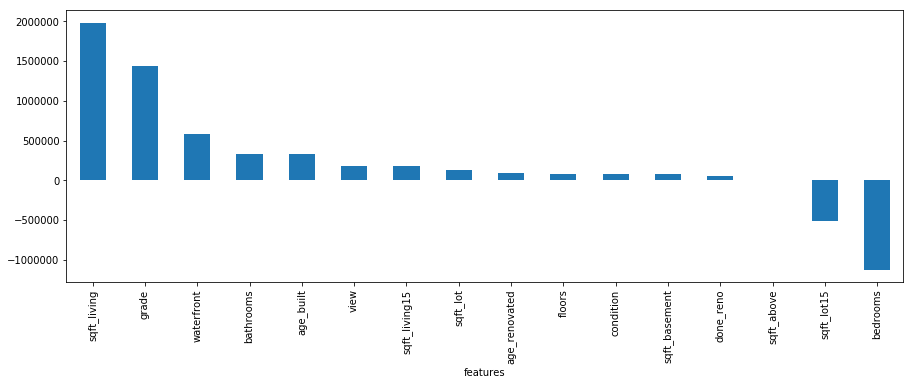

In [53]:
coef_results['Lasso Regression'].sort_values(ascending = False).plot.bar(figsize=(15,5),)
plt.show()

From the coefficient of Lasso regression, we can see that the rank of the coefficients from the top to lowest are `sqft_living`, `grade`, `waterfront`, `bathrooms`, `age_built`, `view`, etc., which is generally aligned with what we've found in EDA. 

For the `waterfront`, this feature didn't stand out in EDA, but it is definetly reasonable when the price is higher with a waterfront.

For `age_built`, we found there no significant trend in EDA analysis. The reason it shows positively correlated is probably due to the influnce of the house age more than 50 years. However, since lasso is a monotonic linear regression, so it can only show either positive correlated or negative. For the training data, the model chose to have positive correlation. 

### Pick the first 10 entries and compare the predicted price

In [54]:
n_rows = 10
y_pred_linear_df = pd.DataFrame(y_pred_linear, columns = ['linear_pred']) 
y_pred_ridge_df = pd.DataFrame(y_pred_ridge, columns = ['ridge_pred']) 
y_pred_lasso_df = pd.DataFrame(y_pred_lasso, columns = ['lasso_pred']) 
model_results = pd.concat([y_test.reset_index(), y_pred_linear_df, y_pred_ridge_df, y_pred_lasso_df], axis = 1, sort = False) 

In [55]:
model_results.head(n_rows)

,index,price,linear_pred,ridge_pred,lasso_pred
0,17384,297000.00,296045.35,294011.05,295612.33
1,722,1578000.00,1478231.35,1471733.12,1477646.02
2,2680,562100.00,505688.42,500407.30,505369.17
3,18754,631500.00,566644.70,561926.96,566222.49
4,14554,780000.00,841695.58,842748.89,842210.02
5,16227,485000.00,298416.65,298888.16,298496.51
6,6631,340000.00,454553.88,455709.21,454704.54
7,19813,335606.00,538849.13,536672.98,538866.12
8,3367,425000.00,649012.01,650358.39,649237.06
9,21372,490000.00,1170954.81,1170818.34,1170701.20


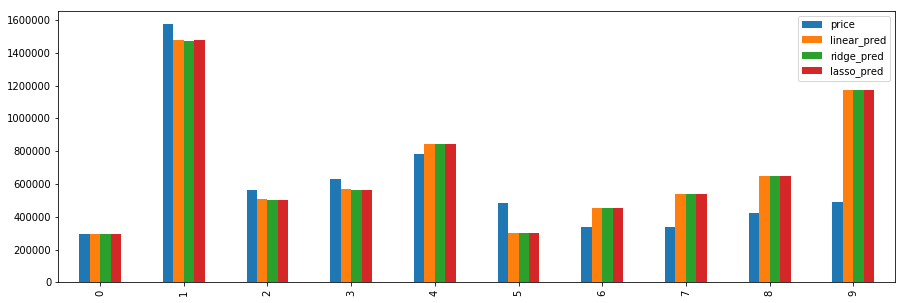

In [56]:
model_results[['price', 'linear_pred', 'ridge_pred', 'lasso_pred']].head(n_rows).plot.bar(figsize = (15, 5))
plt.show()

We can see that three models predicts the same level, the prdicted price for the first 10 row is rougly a little bit more than 50% accurate. We may need other models to improve the accuracy. By changing `n_rows`, users can get a sense of how accrate the models perform.

## Conclusions

1. The price (target) has many outliers, and it is positively skewed, which makes it hard to generate a proper model to predict the price. 
2. From EDA, we understand several key findings:
 - (1) The living square footage is highly correlated with the price.
 - (2) The grade is highly correlated with the price
 - (3) The number of bathrooms positively correlated with the price.
 - (4) The view also determines the price.
 - (5) Since most people don't have a basement, so square footage above the ground is correlated with the living square footage.
 - (6) Usually, the neighborhood has a similar size of the living space.
 - (7) The age of the house doesn't have a clear trend contributing to the price.
 - (8) The house with the renovation can sell slightly higher than the houses they don't.
3. The linear model with or without the regularization performs similarily. With MinMaxScaling of 16 selected features, the R^2 score is around 65.8% accurate for three linear models.
 - (1) Three models have a similar value of the intercept
 - (2) The sign and magnitude of the coefficient (of lasso regression) are generally matched with what we've observed in the EDA.

### Future work:  
Base on the above findings, we found out that linear models have limitations to capture the trend of the price. Although it gave us a decent price prediction (about 65% accurate), it cannot capture the non-linearity of the nature of the housing price. The score can be improved if we try non-linear models such as Random Forest, XGboost, Neural Network, etc.